# **가리기용**

In [2]:
!pip install pydicom matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, zoom
from skimage.segmentation import chan_vese
import nibabel as nib
import pandas as pd

In [4]:
from google.colab import drive
import os
import pydicom
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from scipy.ndimage import gaussian_filter, zoom
from skimage.segmentation import chan_vese
import pandas as pd

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()


Mounted at /content/drive
Current directory: /content/drive/MyDrive


In [ ]:
!tree -L 3q

# **실제코드**

In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

class DICOMProcessingFactory:

    def __init__(self, folder_path: str, start_idx: int, end_idx: int):
        self.folder_path = folder_path
        self.images = self._load_images(start_idx, end_idx)

    def _load_images(self, start_idx: int, end_idx: int) -> list:
        image_files = [filename for filename in os.listdir(self.folder_path) if filename.endswith('.dcm')]
        print(f"Found {len(image_files)} DICOM files in {self.folder_path}")

        images = [[filename[:-4], pydicom.read_file(os.path.join(self.folder_path, filename))] for filename in image_files if start_idx <= int(filename[:-4]) <= end_idx]
        images = sorted(images, key=lambda x: x[0])
        print(f"Loaded {len(images)} DICOM images from index {start_idx} to {end_idx}")

        return [img[1] for img in images]

    def gamma_correction(self, img_array, gamma=1.0):
        if gamma == 0:
            print("Gamma value shouldn't be zero.")
            return

        normalized_img = img_array.astype(np.float32) / 255.0
        corrected_img = np.power(normalized_img, gamma)
        corrected_img = (corrected_img * 255).astype(np.uint8)

        return corrected_img

    def stack_images(self, start_idx, depth):
        if depth == 1:
            return self.images[start_idx].pixel_array
        stack = np.mean([self.images[i].pixel_array for i in range(start_idx, start_idx + depth)], axis=0)
        return stack

    def save_processed_images(self, output_folder):
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        sizes = [(225, 225), (256, 256)]
        depths = [1]
        gammas = [0.5, 0.6, 0.7]

        for depth in depths:
            for idx in range(0, len(self.images) - depth + 1, depth):
                stacked_img = self.stack_images(idx, depth)

                for w, h in sizes:
                    for gamma in gammas:
                        case_folder = f"img_{w}x{h}_d{depth}_g{gamma}"
                        full_case_path = os.path.join(output_folder, case_folder)

                        if not os.path.exists(full_case_path):
                            os.makedirs(full_case_path)

                        resized_img = zoom(stacked_img, (w / stacked_img.shape[0], h / stacked_img.shape[1]))

                        if gamma != 0:
                            processed_img = self.gamma_correction(resized_img, gamma)
                        else:
                            processed_img = resized_img

                        filename_base = f"image_{idx}"

                        if depth > 1:  # Save as .npy for depths greater than 1
                            filename = filename_base + ".npy"
                            output_path = os.path.join(full_case_path, filename)
                            print(f"Saving data to {output_path}")
                            np.save(output_path, processed_img)
                        else:  # Else save as PNG with single channel
                            filename = filename_base + ".png"
                            output_path = os.path.join(full_case_path, filename)
                            print(f"Saving image to {output_path}")
                            plt.imsave(output_path, processed_img, cmap='gray', vmin=0, vmax=255)

# Usage
processor = DICOMProcessingFactory('rsna_data/train_images/10127/53380', start_idx=0, end_idx=2000)
processor.save_processed_images('png_test_lyd/10127/53380')


In [17]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from glob import glob
import gc

# 설정
# BASE_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
BASE_PATH = "rsna_data"
IMAGE_DIR = "yd_test"
STRIDE = 1
config = {
    "RESIZE_DIM": 256  # 원하는 크기로 수정하세요.
}
GAMMAS = [0.5, 0.6, 0.7]  # 적용할 감마 값 리스트

# meta_df 생성 및 CSV 파일 읽기
meta_df = pd.read_csv(f"{BASE_PATH}/test_series_meta.csv")
meta_df["dicom_folder"] = BASE_PATH + "/test_images" + "/" + meta_df.patient_id.astype(str) + "/" + meta_df.series_id.astype(str)
test_folders = meta_df.dicom_folder.tolist()
print(test_folders)
# test_paths 생성
test_paths = []
for folder in tqdm(test_folders):
    test_paths += sorted(glob(os.path.join(folder, "*dcm")))[::STRIDE]

# test_df 생성
test_df = pd.DataFrame(test_paths, columns=["dicom_path"])
test_df["patient_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-3]).astype(int)
test_df["series_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-2]).astype(int)
test_df["instance_number"] = test_df.dicom_path.map(lambda x: x.split("/")[-1].replace(".dcm","")).astype(int)
test_df["image_path"] = f"{IMAGE_DIR}/test_images" + "/" + test_df.patient_id.astype(str) + "/" + test_df.series_id.astype(str) + "/" + test_df.instance_number.astype(str) +".png"

# 디렉터리 초기화 및 생성
os.makedirs(f"{IMAGE_DIR}/train_images", exist_ok=True)
os.makedirs(f"{IMAGE_DIR}/test_images", exist_ok=True)

def standardize_pixel_array(dcm):
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def gamma_correction(img_array, gamma=0.5):
    if gamma == 0:
        print("Gamma value shouldn't be zero.")
        return img_array
    normalized_img = img_array.astype(np.float32) / 255.0
    print(f"Min: {np.min(normalized_img)}, Max: {np.max(normalized_img)}")  # 디버깅을 위한 로깅 추가
    corrected_img = np.power(normalized_img, gamma)
    corrected_img = (corrected_img * 255).astype(np.uint8)
    return corrected_img

def resize_save_gamma_correct(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]
    img = cv2.resize(img, (config["RESIZE_DIM"], config["RESIZE_DIM"]), cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)

    # 원래의 DICOM 파일 이름을 사용하여 sub_path 생성
    original_file_name = os.path.basename(file_path).replace(".dcm", ".png")
    sub_path = os.path.join(os.path.dirname(file_path).replace(BASE_PATH, IMAGE_DIR), original_file_name)
    print(sub_path)
    new_path = sub_path

    os.makedirs(new_path.rsplit("/", 1)[0], exist_ok=True)

    # 감마 교정 및 저장
    for gamma in GAMMAS:
        corrected_img = gamma_correction(img, gamma)
        gamma_path = new_path.replace("/test_images", f"/gamma_{gamma}_images")
        os.makedirs(os.path.dirname(gamma_path), exist_ok=True)

        # 파일 저장 성공 여부 확인
        if not cv2.imwrite(gamma_path, corrected_img):
            print(f"Failed to save image at {gamma_path}")
    return

# 병렬 처리 및 실행
file_paths = test_df.dicom_path.tolist()
_ = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_save_gamma_correct)(file_path) for file_path in tqdm(file_paths, leave=True, position=0)
)
test_paths = []

# 메모리 정리
del _
gc.collect()


['rsna_data/test_images/48843/295', 'rsna_data/test_images/48843/62825', 'rsna_data/test_images/50046/24574', 'rsna_data/test_images/50046/60658', 'rsna_data/test_images/63706/39279', 'rsna_data/test_images/63706/41385']


100%|██████████| 3/3 [00:00<00:00, 2001.10it/s]

yd_test/test_images/48843/62825/30.png
yd_test/test_images/50046/24574/30.png
Min: 0.0, Max: 0.7843137383460999
Min: 0.0, Max: 0.929411768913269
Min: 0.0, Max: 0.7843137383460999
Min: 0.0, Max: 0.929411768913269
Min: 0.0, Max: 0.7843137383460999
Min: 0.0, Max: 0.929411768913269
yd_test/test_images/63706/39279/30.png
Min: 0.0, Max: 0.8980392217636108
Min: 0.0, Max: 0.8980392217636108
Min: 0.0, Max: 0.8980392217636108


67

# **파일 규격확인코드**

In [ ]:
import os
import pydicom

class DICOMLoader:

    def __init__(self, folder_path: str):
        self.folder_path = folder_path
        self.images = self._load_images()

    def _load_images(self) -> list:
        image_files = [filename for filename in os.listdir(self.folder_path) if filename.endswith('.dcm')]
        print(f"Found {len(image_files)} DICOM files in {self.folder_path}")
        return [pydicom.read_file(os.path.join(self.folder_path, filename)) for filename in image_files]

    def display_image_shapes(self):
        for idx, img in enumerate(self.images):
            array = img.pixel_array
            if len(array.shape) == 2:  # Grayscale image
                print(f"Image {idx + 1}: Width: {array.shape[1]}, Height: {array.shape[0]}, Depth: 1, Channels: 1")
            elif len(array.shape) == 3:  # Color image (very uncommon in DICOM)
                print(f"Image {idx + 1}: Width: {array.shape[1]}, Height: {array.shape[0]}, Depth: 1, Channels: {array.shape[2]}")
            else:  # Some other shape
                print(f"Image {idx + 1} has an unusual shape: {array.shape}")

# Usage
loader = DICOMLoader('path_to_your_dicom_folder')
loader.display_image_shapes()

In [ ]:
import os
from PIL import Image

class PNGLoader:

    def __init__(self, folder_path: str):
        self.folder_path = folder_path
        self.images = self._load_images()

    def _load_images(self) -> list:
        image_files = [filename for filename in os.listdir(self.folder_path) if filename.endswith('.png')]
        print(f"Found {len(image_files)} PNG files in {self.folder_path}")
        return [Image.open(os.path.join(self.folder_path, filename)) for filename in image_files]

    def display_image_shapes(self):
        for idx, img in enumerate(self.images):
            width, height = img.size
            if len(img.getbands()) == 1:  # Grayscale image
                print(f"Image {idx + 1}: Width: {width}, Height: {height}, Depth: 1, Channels: 1")
            else:  # Color image
                print(f"Image {idx + 1}: Width: {width}, Height: {height}, Depth: 1, Channels: {len(img.getbands())}")
            # print()
# Usage
loader = PNGLoader('png_test_lyd/img_225x225_d1_g0.2')  # Update the folder path to your PNG folder
loader.display_image_shapes()


FileNotFoundError: ignored

In [ ]:
import os
import numpy as np

class NPYLoader:

    def __init__(self, folder_path: str):
        self.folder_path = folder_path
        self.arrays = self._load_arrays()

    def _load_arrays(self) -> list:
        array_files = [filename for filename in os.listdir(self.folder_path) if filename.endswith('.npy')]
        print(f"Found {len(array_files)} NPY files in {self.folder_path}")
        return [np.load(os.path.join(self.folder_path, filename)) for filename in array_files]

    def display_array_shapes(self):
        for idx, array in enumerate(self.arrays):
            height, width = array.shape[:2]
            if len(array.shape) == 2:  # 2D array
                print(f"Array {idx + 1}: Width: {width}, Height: {height}, Depth: 1, Channels: 1")
            elif len(array.shape) == 3:  # 3D array (could be multiple channels or depth slices)
                depth_or_channels = array.shape[2]
                print(f"Array {idx + 1}: Width: {width}, Height: {height}, Depth: {depth_or_channels}, Channels: {depth_or_channels}")
            else:  # Some other shape
                print(f"Array {idx + 1} has an unusual shape: {array.shape}")
            print(array.shape)
# Usage
loader = NPYLoader('png_test_lyd/img_225x225_d10_g0.1')  # Update the folder path to your NPY folder
# loader = NPYLoader('png_test_lyd/img_225x225_d10_g0.2')  # Update the folder path to your NPY folder
# loader = NPYLoader('png_test_lyd/img_225x225_d10_g0.8')  # Update the folder path to your NPY folder
loader.display_array_shapes()


Found 102 NPY files in png_test_lyd/img_225x225_d10_g0.1
Array 1: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 2: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 3: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 4: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 5: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 6: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 7: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 8: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 9: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 10: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 11: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 12: Width: 225, Height: 225, Depth: 10, Channels: 10
(225, 225, 10)
Array 13: Width: 225, Height: 225, Depth: 10, Channels: 10
(225,

Found 102 NPY files in png_test_lyd/img_256x256_d10_g0.6


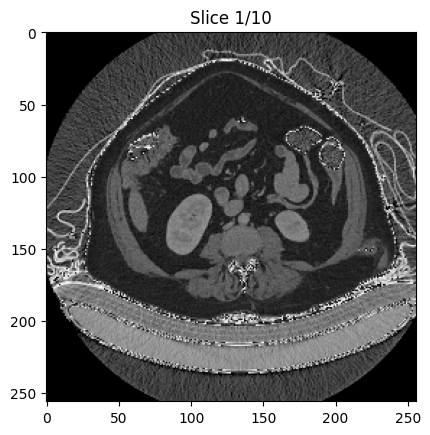

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NPYViewer:

    def __init__(self, array: np.ndarray):
        self.array = array
        self.depth = array.shape[2]
        self.current_slice = 0

        # Display the initial slice
        self._display_slice(self.current_slice)

    def _display_slice(self, slice_idx: int):
        plt.imshow(self.array[:, :, slice_idx], cmap='gray')  # cmap='gray' for grayscale, adjust as needed
        plt.title(f'Slice {slice_idx + 1}/{self.depth}')
        plt.show()

    def next_slice(self):
        if self.current_slice < self.depth - 1:
            self.current_slice += 1
            self._display_slice(self.current_slice)
        else:
            print("Reached the last slice.")

    def prev_slice(self):
        if self.current_slice > 0:
            self.current_slice -= 1
            self._display_slice(self.current_slice)
        else:
            print("Reached the first slice.")

# Usage
loader = NPYLoader('png_test_lyd/img_256x256_d10_g0.6')  # Update the folder path to your NPY folder
viewer = NPYViewer(loader.arrays[74])  # Displaying the 75th array

# Use viewer.next_slice() to see the next slice and viewer.prev_slice() to see the previous slice

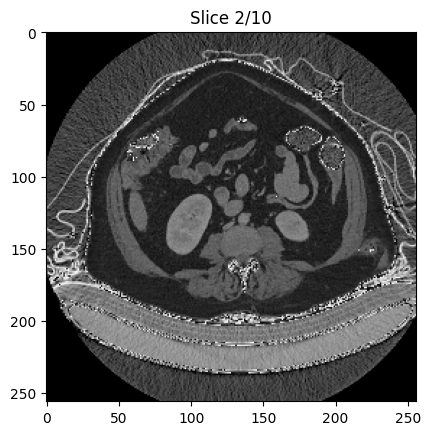

In [ ]:
viewer.next_slice()